The aim of this notebook is to train a simple diffusion-like model to generate
MNIST-like images. It's inspired by https://huggingface.co/learn/diffusion-course/en/unit1/3.

### Imports & constants

In [2]:
import sys
sys.path.append('../src')

In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchvision import transforms
from tqdm import tqdm

from models import UNet

In [4]:
BATCH_SIZE = 32
NUM_EPOCHS = 10
LR = 1e-4

### Helper functions

In [5]:
def show_tensor_imgs(x: torch.Tensor, title: str = '', from_gpu: bool = False):
    if from_gpu:
        x = x.detach().cpu().clip(0, 1)  # Clip just in case predictions are a bit off

    plt.title(title)
    plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

### Loading data

In [ ]:
dataset = torchvision.datasets.MNIST(
    root='../local',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

x, _ = next(iter(dataloader))
x = x[:8]  # Take only a few images for visualizations

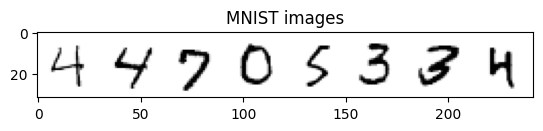

In [7]:
show_tensor_imgs(x, 'MNIST images')

### Corruption

In [8]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt images from `x` with random noise from [0, 1] interval.

    Each image is corrupted to a different degree, according to `amount`,
    which should be a 1D tensor of size 1 or `x.shape[0]`.
    """

    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # To make sure broadcasting works

    return x*(1-amount) + noise*amount

Let's see how various degrees of corruption look.

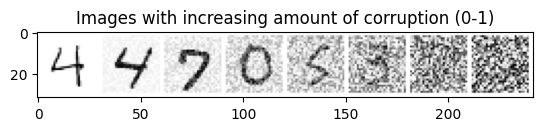

In [9]:
amount = torch.linspace(0, 1, x.shape[0])
x_corr = corrupt(x, amount)

show_tensor_imgs(x_corr, 'Images with increasing amount of corruption (0-1)')

### Model & other stuff before training

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

### Training

In [12]:
for epoch in range(NUM_EPOCHS):
    tqdm_it = tqdm(dataloader, total=len(dataloader), leave=True)
    tqdm_it.set_description(f'Epoch: [{epoch+1}/{NUM_EPOCHS}]')

    for x, _ in tqdm_it:
        x = x.to(device)
        amount = torch.rand(x.shape[0]).to(device)
        x_corr = corrupt(x, amount)

        x_reconstr = model(x_corr)
        loss = loss_fn(x_reconstr, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tqdm_it.set_postfix(loss=loss.item())

Epoch: [10/10]: 100%|██████████| 1875/1875 [00:25<00:00, 74.70it/s, loss=0.0135]


### Sampling

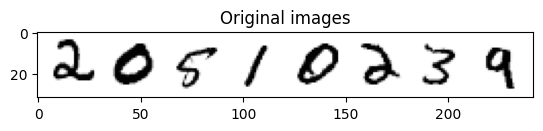

In [13]:
x, _ = next(iter(dataloader))
x = x[:8]

show_tensor_imgs(x, 'Original images')

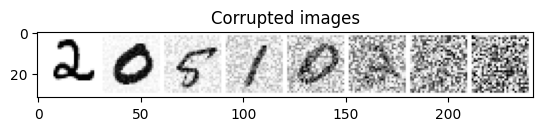

In [14]:
x = x.to(device)
amount = torch.linspace(0, 1, x.shape[0]).to(device)
x_corr = corrupt(x, amount)

show_tensor_imgs(x_corr, 'Corrupted images', from_gpu=True)

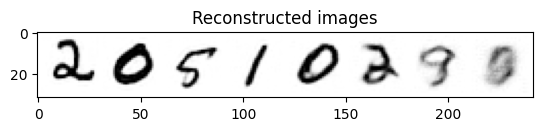

In [15]:
with torch.no_grad():
    x_reconstr = model(x_corr)

show_tensor_imgs(x_reconstr, 'Reconstructed images', from_gpu=True)

### Sampling in multiple steps

Let's generate images in multiple steps (for each step, next prediction
is a weighted sum of the current image and the current prediction, where
the prediction's weight increases over time).

In [16]:
N_SAMPLING_STEPS = 10

In [17]:
inputs = []
preds = []

x = torch.rand(8, 1, 28, 28).to(device)

for i in range(N_SAMPLING_STEPS):
    inputs.append(x.cpu())

    with torch.no_grad():
        pred = model(x)
    preds.append(pred.cpu())

    mix_factor = 1 / (N_SAMPLING_STEPS - i)
    x = mix_factor*pred + (1-mix_factor)*x

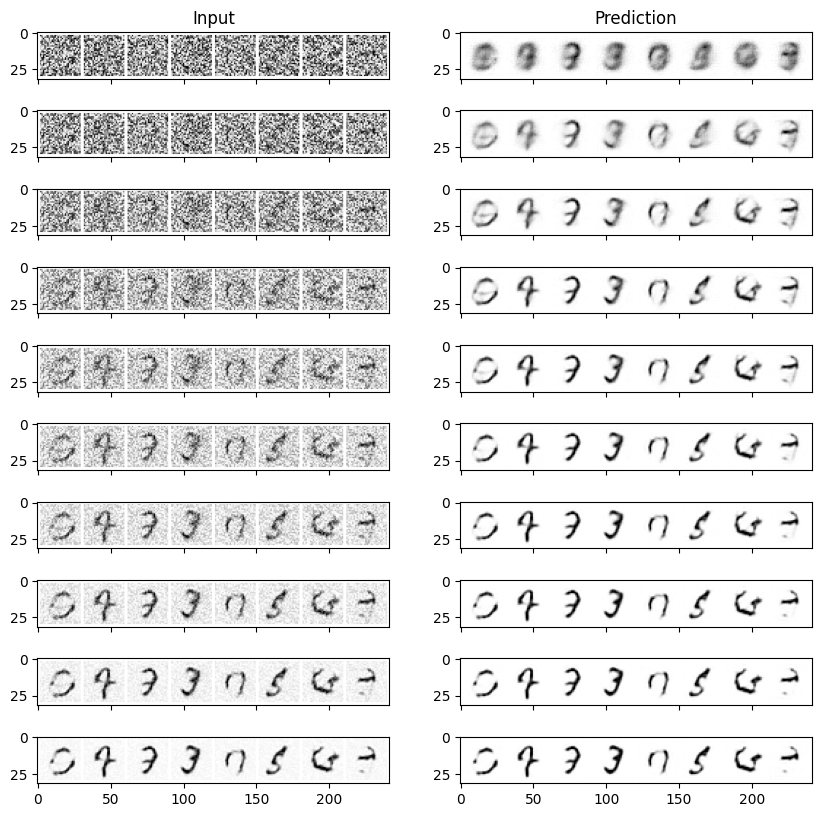

In [18]:
fig, axs = plt.subplots(N_SAMPLING_STEPS, 2, figsize=(10, N_SAMPLING_STEPS), sharex=True)
axs[0, 0].set_title('Input')
axs[0, 1].set_title('Prediction')

for i in range(N_SAMPLING_STEPS):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(inputs[i])[0].clip(0, 1), cmap='Greys'
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(preds[i])[0].clip(0, 1), cmap='Greys'
    )